In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numba
from itertools import product
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['savefig.dpi']=400

In [2]:
dau=pd.read_csv("practice_dau_and.csv",sep="|",header=None,engine="c",names=["id","country","number_of_pgr","actdate"],
                dtype={"number_of_pgr":"int16"},
                parse_dates=[3],na_filter=False).sort_values(by=["id","actdate","number_of_pgr"]).drop_duplicates(
    subset=["id","actdate"],keep="last")
pact=pd.read_csv("practice_pact_and.csv",sep="|",header=None,engine="c",names=
                ["id","actdate","regdate","clusters_ml_ended","revenue","transactions","quests_end","m_quests_end",
                "crystals_value_spend","store_enters"],usecols=["id","actdate","regdate","clusters_ml_ended",
                "revenue","transactions","quests_end","m_quests_end"],dtype={"clusters_ml_ended":"int8",
                "revenue":"float32","transactions":"int8","quests_end":"int16","m_quests_end":"int16"},
                 parse_dates=[1,2])
pact=pact.drop("regdate",axis=1).join(pact.groupby("id").regdate.min().to_frame(),on="id")
pact=pd.merge(dau,pact,on=["id","actdate"],copy=False)
lenc_cntr=LabelEncoder()
lenc_id=LabelEncoder()
pact.country=lenc_cntr.fit_transform(pact.country.values).astype("uint8")
pact.id=lenc_cntr.fit_transform(pact.id.values).astype("uint32")
del dau

In [3]:
days_obs=7
days_pred=30

In [4]:
y=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_pred-1)].groupby("id").revenue.sum().to_frame()
y.loc[y.revenue>1000,"revenue"]=1000

In [5]:
pact_train=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_obs-1)].copy()
pact_train.loc[:,"day"]=(pact_train["actdate"]-pact_train["regdate"]).dt.days
pact_train=pact_train.set_index(["id","day"]).reindex(pd.MultiIndex.from_product([pact_train["id"].unique(), range(days_obs)], names=["id", "day"]))
pact_train.regdate.fillna(method="ffill",inplace=True)
pact_train.country.fillna(method="ffill",inplace=True)

In [6]:
pact_train.actdate=pact_train.apply(lambda x:timedelta(days=x.name[1])+x.regdate, axis=1,reduce=False)
pact_train.fillna(0,inplace=True)

In [7]:
pact_train["regmonth"]=pact_train.regdate.dt.month
pact_train["regday"]=pact_train.regdate.dt.day
pact_train["actmonth"]=pact_train.actdate.dt.month
pact_train["actday"]=pact_train.actdate.dt.day
pact_train=pact_train.drop(["regdate","actdate"],axis=1).reset_index().pivot(index="id",columns="day").drop(
    [col for col in product(["regmonth","regday","country"],range(1,days_obs))],axis=1)

In [8]:
pact_train.columns=["".join(map(str,col)) for col in pact_train.columns]
pact_train.rename(columns={"regmonth0":"regmonth","regday0":"regday","country0":"country"},inplace=True)
pact_train.index.name=None

In [9]:
cleaned=pd.merge(pact_train,y,left_index=True,right_index=True)
print(len(cleaned[(cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17))])/len(cleaned))
train=cleaned[(cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17))]
test=cleaned[~((cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17)))]

0.7496734218639626


In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor, plot_importance, early_stopping

In [11]:
regr1=LGBMRegressor(n_estimators=58)

In [12]:
regr1.fit(train.drop("revenue",axis=1),train.revenue)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0, n_estimators=58, nthread=-1, num_leaves=31,
       objective='regression', reg_alpha=0, reg_lambda=0, seed=0,
       silent=True, subsample=1, subsample_for_bin=50000, subsample_freq=1)

In [13]:
r2_score(test.revenue,regr1.predict(test.drop("revenue",axis=1)))

0.81234189410480018

In [14]:
mean_squared_error(test.revenue,regr1.predict(test.drop("revenue",axis=1)))

3449.8475334894774

In [15]:
np.sqrt(mean_squared_error(test.revenue,regr1.predict(test.drop("revenue",axis=1))))

58.735402726885916

In [16]:
mean_absolute_error(test.revenue,regr1.predict(test.drop("revenue",axis=1)))

6.5711941676531085

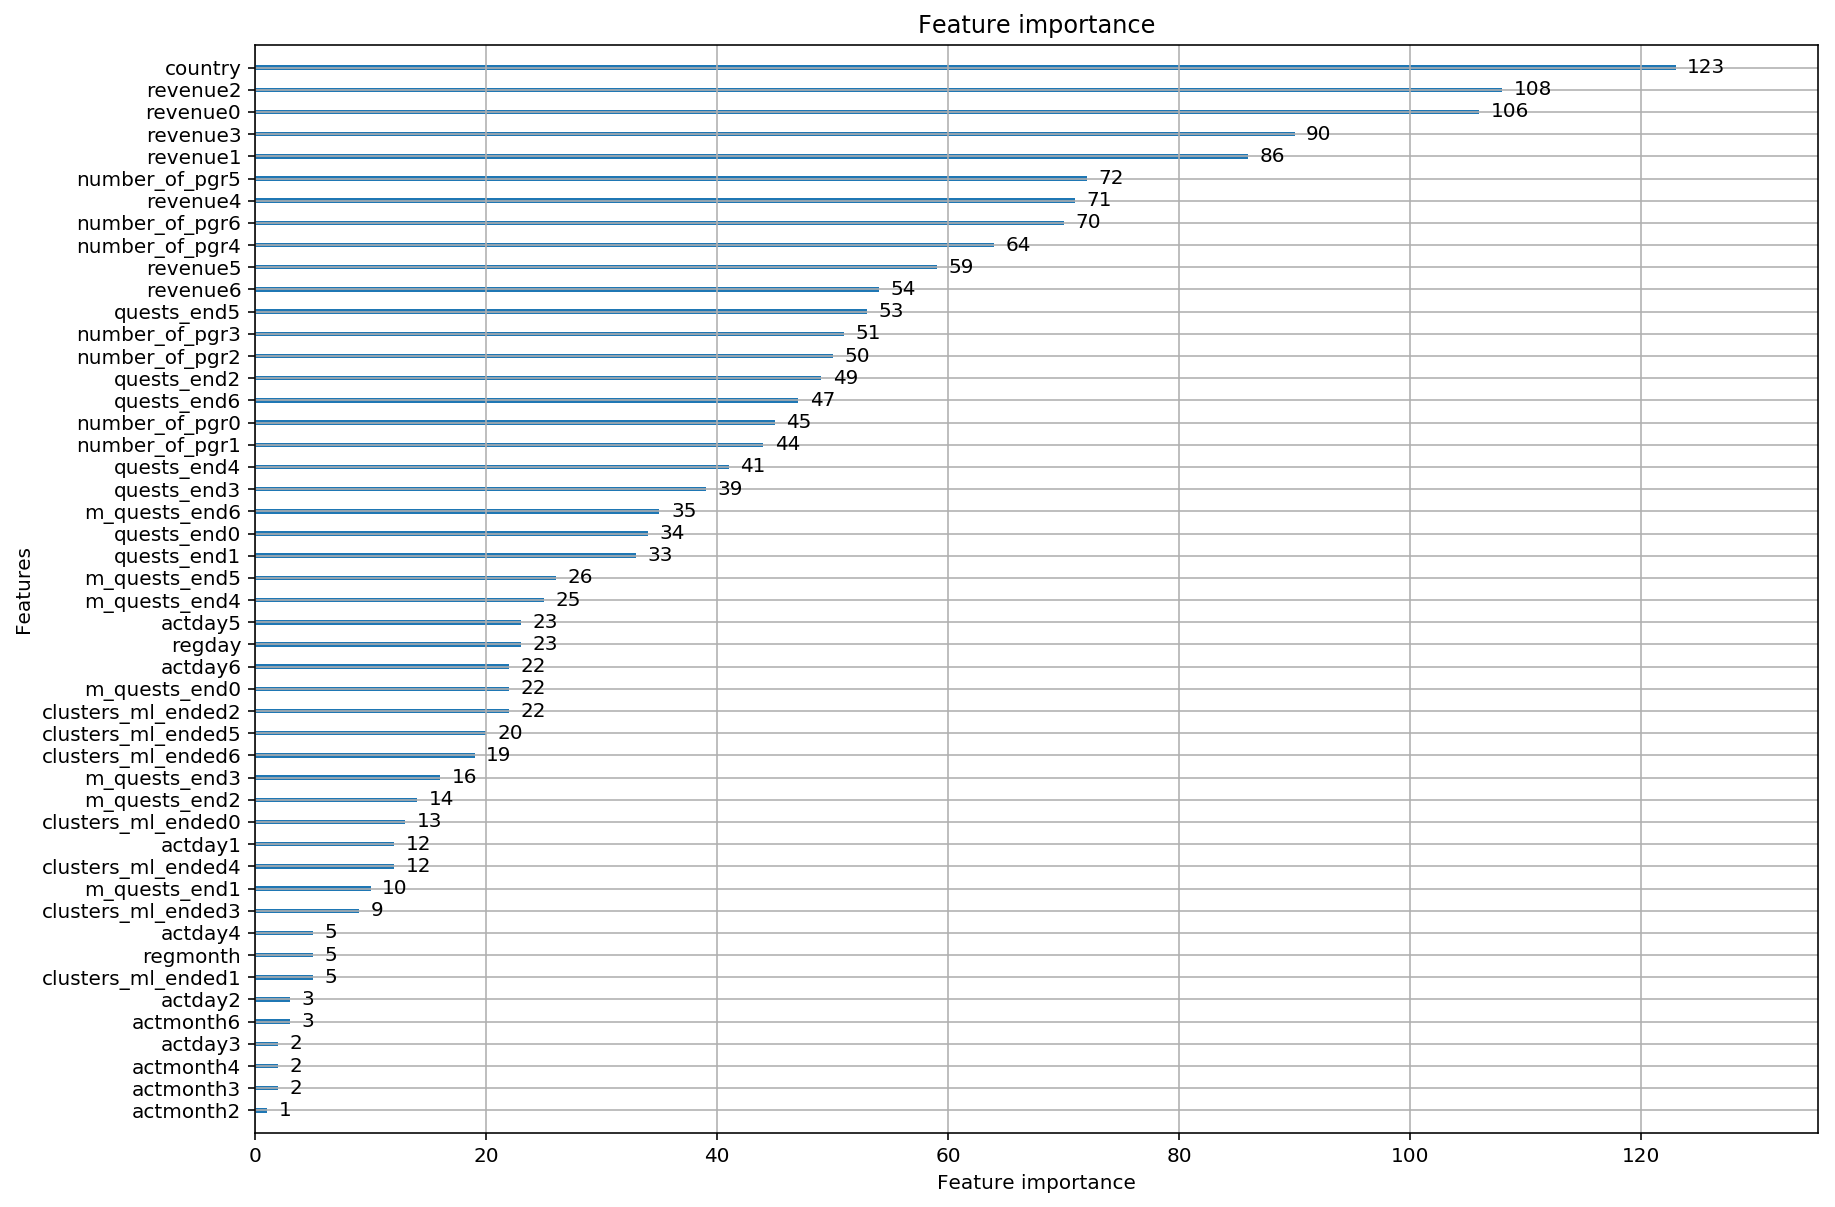

In [17]:
plot_importance(regr1)

In [ ]:
oneday=test[(test.regmonth==5)&(test.regday==1)]
true_sum=oneday.revenue.sum()
true_sum

In [ ]:
regr1.predict(oneday.drop("revenue",axis=1)).sum()

In [ ]:
from sklearn.model_selection import GridSearch

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [ ]:
regr2=ElasticNet()
regr3=RandomForestRegressor()
regr4=ExtraTreesRegressor()
regr5=GradientBoostingRegressor(subsample=0.85)

In [ ]:
whos